In [1]:
# importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import pandas as pd

import os
cwd = os.getcwd()

%run ../functions_MCMC

In [2]:
# define variables
data_seed = 1223
burnin = 10000 #10k
n_after_burnin = 10000 #10k
delta_t = 0.3

#T=60 gives 200 delta_y
T = 60
n_chains = 4
n_sim = 1

V_F = 2000
V_B = -1500
V = np.array([V_F, V_B])
Lambda = np.array([1, 0.5])
log_Lambda = np.log(Lambda)
P = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma = 50.0
n = Lambda.shape[0]
n_param = 5

parameter_names = ['v1', 'v2', 'loglambda1', 'loglambda2', 'sigma']
parameter_names_tex = [r'$v_1$', r'$v_2$', r'log($\lambda_1$)',
                       r'log($\lambda_2$)', r'$\sigma$']

#choose initial covariance matrix for resampling
init_cov_matrix = np.array([np.diag(np.array([0.1, 0.1, 0.0001, 0.0001, 0.01]))
                            for _ in range(n_chains)])

correlated = True
up_to_switches = 1
track = True

plots = False
save = True
all_plots = False
plot_posteriors_grid = True
plot_fit = False
plot_fit_median = True

theta_true = list(V) + list(log_Lambda) + [sigma] #not including values for P for 2x2

In [3]:
#THIS STILL NEEDS TO BE MODIFIED FOR SEVERAL CASES
def get_parameters(theta):
    V = np.zeros(2)
    V[0] = 1.0*theta[0]
    V[1] = 1.0*theta[1]
    Lambda = 1.0*np.exp(np.array(theta[2:4]))
    P = np.zeros((2,2))
    P[0,1] = 1.0
    P[1,0] = 1.0
    sigma = 1.0*theta[-1]
    
    return V, Lambda, P, sigma

def q(theta, cov_matrix=init_cov_matrix):
    """q samples a new theta_star given theta"""
    theta_star = np.random.multivariate_normal(theta, cov_matrix)
    while (theta_star[0]<0 or theta_star[0]>2.0*V_F or 
           theta_star[1]>0 or theta_star[1]<2.0*V_B or 
           np.any(theta_star[2:4]<-4) or np.any(theta_star[2:4]>4) or
           theta_star[-1]<0 or np.any(theta_star[-1]>2.0*sigma)):
        theta_star = np.random.multivariate_normal(theta, cov_matrix)
    return theta_star

def theta_init_uniform(seed):
    np.random.seed(seed)
    rand_vec = np.random.uniform(size=5)
    theta = ((np.array([2.0*V_F, 2.0*V_B, 8.0, 8.0, 2.0*sigma])*rand_vec)
              +np.array([0.0, 0.0, -4.0, -4.0, 0.0]))
    #print('theta_init =', get_parameters(theta))
    return theta

Iteration 0
Running the burnin and adaptively computing the covariance matrices for each chain.


/home/ceccarelli/Documents/MODEL CALIBRATION MCMC/functions_MCMC.py:697: RuntimeWarning: invalid value encountered in divide
  ret = sum([P_delta_y_i_and_st_ip1_giv_st_i(i-1, st, st_im1)
/home/ceccarelli/Documents/MODEL CALIBRATION MCMC/functions_MCMC.py:740: RuntimeWarning: divide by zero encountered in log
  log_like = np.sum(np.log(approx_pdf_theta(theta, get_parameters, delta_t, delta_y,


Computed the covariance matrices.
Running MCMC with 4 chains
done
R_hat = [1.0008249  1.0012063  1.00014242 1.00012892 1.00000166]


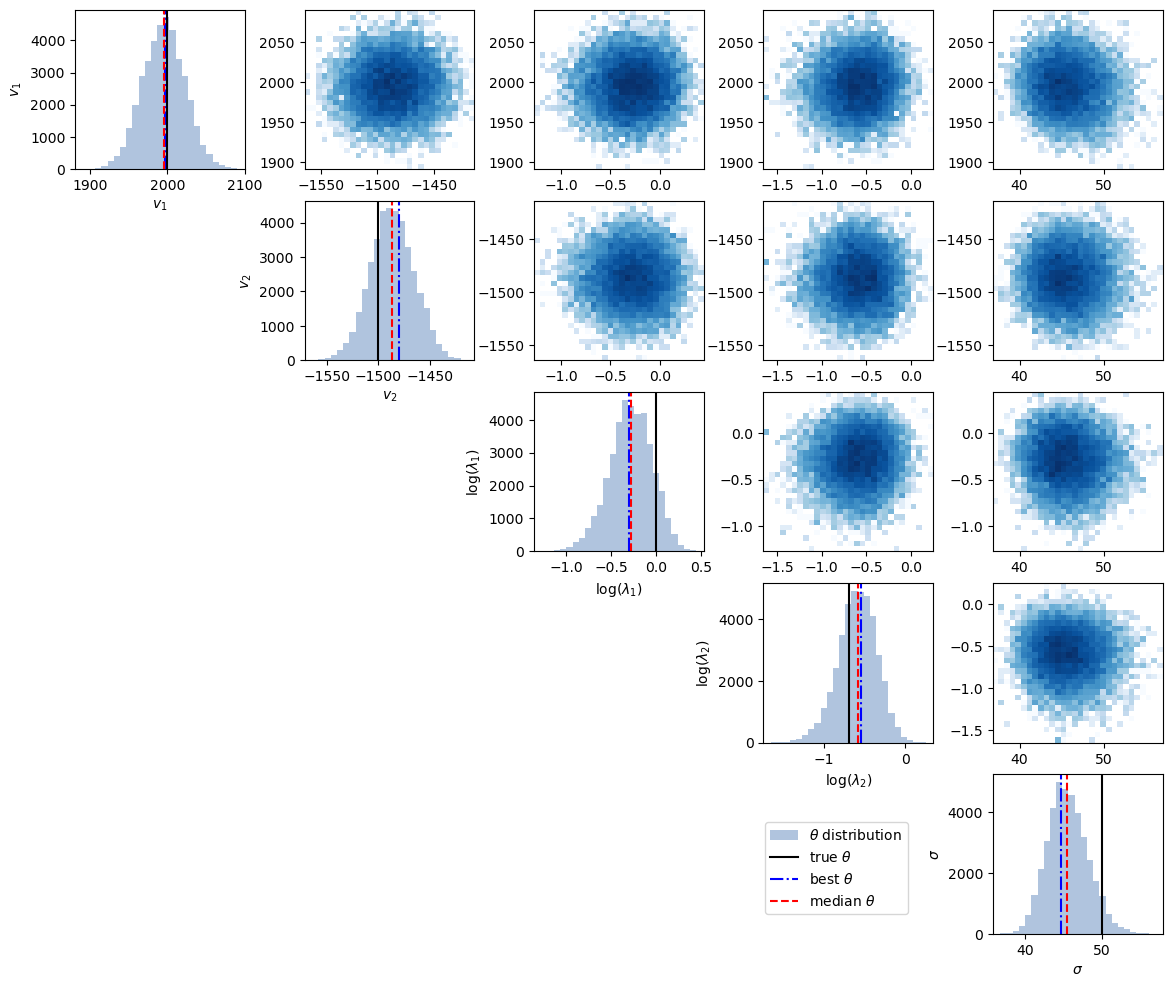

Done simulation 0
Not converged: 0


In [4]:
all_theta, all_log_pi, _, _, dY = distinct_track_runs_MCMC(theta_true = theta_true,
                                 get_parameters = get_parameters,
                                 parameter_names = parameter_names,
                                 parameter_names_tex = parameter_names_tex,
                                 burnin = burnin, n_after_burnin = n_after_burnin,
                                 delta_t = delta_t, T = T,
                                 n_chains = n_chains, n_sim = n_sim,
                                 plots = plots, save = save, all_plots = all_plots,
                                 plot_posteriors_grid = plot_posteriors_grid,
                                 plot_fit = plot_fit,
                                 plot_fit_median = plot_fit_median, track = track,
                                 up_to_switches = up_to_switches,
                                 init_cov_matrix = init_cov_matrix, q = q,
                                 delta_Y = None,
                                 theta_init = None,
                                 theta_init_distribution = theta_init_uniform,
                                 correlated = correlated)

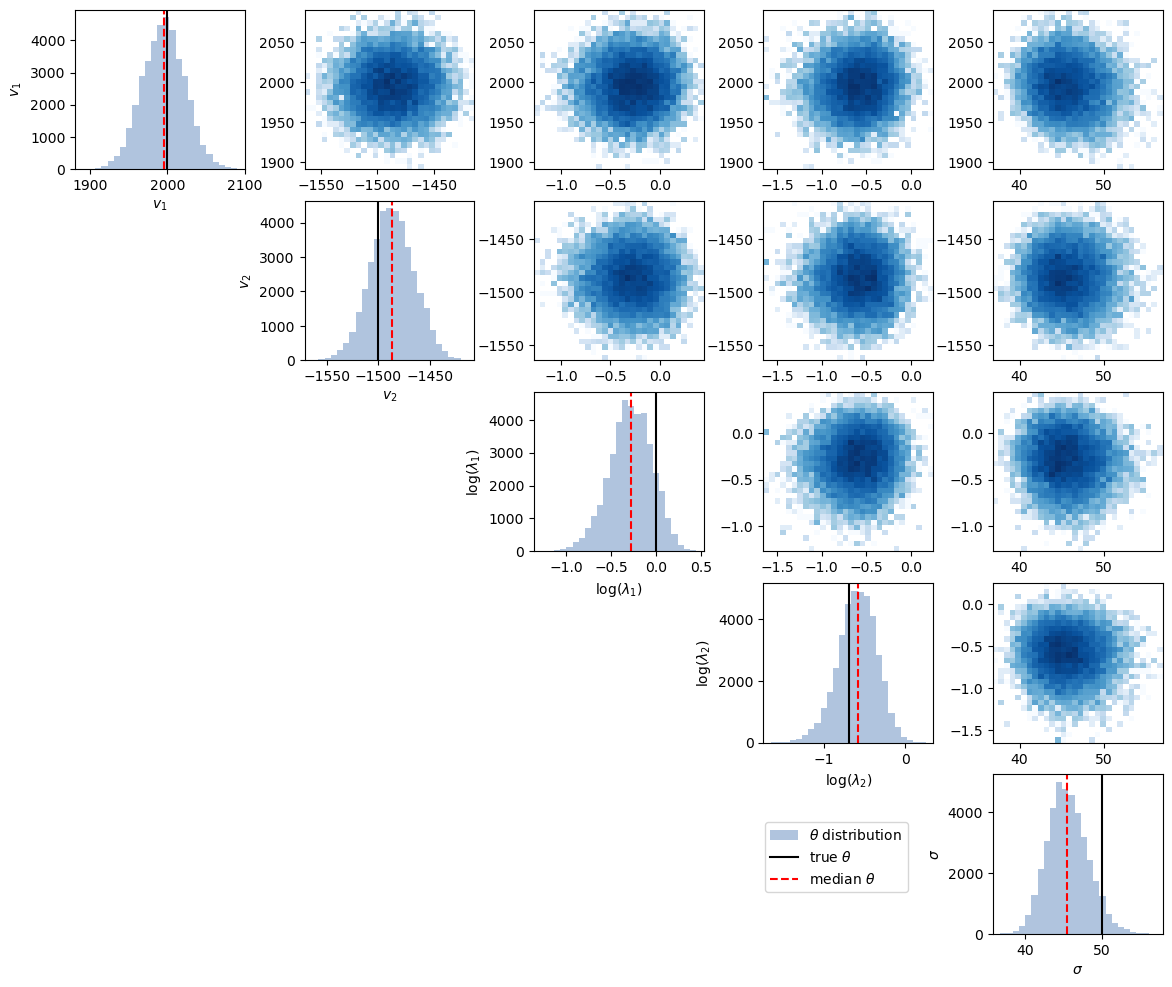

In [7]:
flat_all_theta = np.array([list(all_theta[i,:,:,:].flatten()) for i in range(n_param)])
plots_2_mult(flat_all_theta, theta_true, n_sim, n_param, parameter_names_tex,
             None)

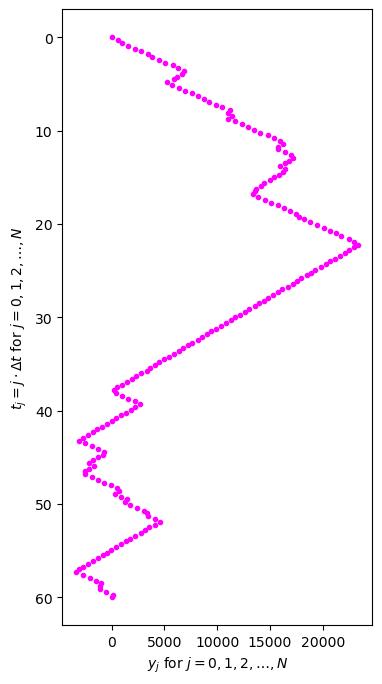

In [6]:
N = 200
rebuild_y = np.zeros(N+1)
for i in range(1, N+1):
    rebuild_y[i] += rebuild_y[i-1] + dY[0,i-1]
plt.figure(figsize=(4,8))
plt.plot(rebuild_y,delta_t*np.arange(0,N+1), '.', color='magenta')
plt.xlabel(r'$y_j$ for $j=0,1,2,\ldots,N$')
plt.ylabel(r'$t_j = j\cdot \Delta t$ for $j=0,1,2,\ldots,N$')
plt.gca().invert_yaxis()
plt.savefig('y_plot_track_0.png', format="png", dpi=1200, bbox_inches="tight")
plt.show()